If you've worked with OpenAI's Completions API and used LLMs for autocomplete tasks, you're likely aware that much of the magic lies in the art of prompt engineering. Crafting the right prompt is essential, but during iterations, one often loses track of the variations, or stashes good ones in a makeshift library, perhaps a spreadsheet.

Enter **PromptStash**. It's your solution to maintaining every prompt iteration. Whether you need to revisit an older version, share it with your developer, or A/B test within your app, PromptStash has you covered.

**About this tutorial:**
We'll delve into a hands-on approach to translate English to Japanese using OpenAI's Completions API. Along the way, we'll iterate on our prompt templates, and introduce you to the concept of PromptOps - the comprehensive management of a prompt's lifecycle - using PromptStash:
- Start with crafting a Prompt Template and test it using the Completions API.
- Archive this template using AI Hero's PromptStash and learn retrieval techniques.
- Engage in iterative refinement of our prompt.
- Construct a Test Suite to evaluate the prompt's effectiveness.
- Discuss prompt deployment best practices.

**Bonus Takeaways:**
- Uncover potential pitfalls and accelerators for swift prompt iteration.
- Access handy code snippets for prompt tracing in your applications, giving you a transparent view into each prompt's journey.

Before we begin, let's install the necessary libraries. If you encounter any issues with the libraries not being recognized after installation, consider restarting your notebook.

In [1]:
%pip install openai aihero python-dotenv
%pip install emoji --upgrade

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Use Case: Chatting with a Japanese-speaking Friend using OpenAI's Completions API
Imagine you want to communicate with a friend who speaks Japanese. For this scenario, we'll craft a prompt template that translates English into Japanese.

### Setting Up OpenAI

#### Using dotenv for Security

We'll employ the dotenv library. This lets us securely load our API keys from a .env file, ensuring we don't mistakenly embed sensitive keys directly in our code.

Begin by creating a .env file in the same directory as this notebook. Insert your OpenAI API key as follows:

In [2]:
# Load the environment vars from a .env file
import os
import dotenv
dotenv.load_dotenv('.env')

assert "OPENAI_API_KEY" in os.environ, "Please set your OPENAI_API_KEY in a .env file."

#### Initializing the OpenAI Client

Now, let's set up our OpenAI client. We'll fetch the API key and Organization ID as guided by the OpenAI [documentation](https://platform.openai.com/docs/introduction).

In [3]:
import openai
# Make sure the key from the .env file works.
assert len(openai.Model.list())

### Crafting Your Initial Prompt Template

The OpenAI completions API works by taking a prompt as input and producing an output. To make prompts more versatile, especially when context or variables change, we use prompt templates. These templates contain placeholders for variables that can be filled dynamically during runtime. Typically, these placeholders are formatted using Python's f-string style or the Jinja2 templating language.

Think of the prompt template as instructions for the Large Language Model (LLM). The LLM will try to "complete" these instructions based on its trained knowledge. For this tutorial, we're focusing on language translation.

Note: This is a basic use case for demonstration purposes. Feel free to adapt and modify the template below to suit your needs!

In [4]:
TEMPLATE_STR = """Translate the following text into Japanese:
{text}

Translation:"""


print(f"TEMPLATE:\n--------------\n{TEMPLATE_STR}\n----------------")

TEMPLATE:
--------------
Translate the following text into Japanese:
{text}

Translation:
----------------


Before feeding our prompt to OpenAI, we must replace the placeholders with actual text. Let's craft a helper function to handle this substitution for us.



In [5]:
def render_prompt_from_template(template:str, text: str) -> str:
  # Pass in the template and text to inject into it.
  # Since the variable is in the prompt using an f-string, we can use the format function to replace it.
  return template.format(text=text).strip()

Now that our function is ready, let's give it a spin to see it in action.

In [6]:
text = "Hello! How are you?"
template = TEMPLATE_STR

prompt = render_prompt_from_template(template=template, text=text)

print(f"Prompt:\n--------------\n{prompt}\n----------------")

Prompt:
--------------
Translate the following text into Japanese:
Hello! How are you?

Translation:
----------------


Excellent! With that working well, let's proceed.


#### Building a Helper for OpenAI Client Initialization and Completion Retrieval

Next, we'll develop a helper function to both initialize the OpenAI client and fetch prompt completions.

In [7]:
MODEL = "text-davinci-003"
MAX_TOKENS = 250
TEMPERATURE = 0

In [8]:
def complete(prompt:str)->str:
  response = openai.Completion.create(
    model=MODEL,
    prompt=prompt.strip(),
    max_tokens=MAX_TOKENS,
    temperature=TEMPERATURE
  )
  return response["choices"][0]["text"].strip()

Let's test it out with our prompt!

In [9]:
completion = complete(prompt)
print(f"Completion:\n--------------\n{completion}\n----------------")

Completion:
--------------
こんにちは！お元気ですか？
----------------


Yatta! Works as expected! We should just create a `translate` function to make it easier.


In [10]:
def translate(template:str, text:str, verbose:bool=False)->str:
  if verbose:
    print(f"English:\n--------------\n{text}\n----------------")
  translation = complete(render_prompt_from_template(template=template, text=text))
  if verbose:
    print(f"Japanese:\n--------------\n{translation}\n----------------")
  return translation

In [11]:
translation = translate(template=TEMPLATE_STR, text="Hello! My name is Rahul, How are you?", verbose=True)

English:
--------------
Hello! My name is Rahul, How are you?
----------------
Japanese:
--------------
こんにちは！私の名前はラフールです、お元気ですか？
----------------


This looks great! Let's see what your friend thinks.

## Refining Your Prompt

Your new ability to chat in Japanese impresses your friend, and she's thrilled! However, she mentions the translations come across a bit formal. As a tidbit, Japanese has distinct forms for polite/formal and casual conversations. To strike a friendlier tone, you'll want to adapt the prompt template.

But hold on! Before making changes, remember the value of preserving our work. Directly editing the prompt string risks losing previous versions. What if we need to revert to an older version? Relying on memory or an 'undo' action isn't the most efficient.

Enter PromptStash – our safeguard against lost iterations.

### Setting up with AI Hero

#### Getting Started with AI Hero:

First, sign in to [AI Hero](https://app.aihero.studio). Upon login, you'll find a default project set up for you. If you wish, you can also create a new project.

#### Integrating with PromptStash:

Within your project, navigate to the PromptStash tool.

In PromptStash, you'll find initialization code that includes both your Project ID and the API Key specific to that project. To securely store these details, add them to your .env file:

    ```
    AI_HERO_PROJECT_ID="YOUR PROJECT ID"
    AI_HERO_PROJECT_API_KEY="YOUR PROJECT API KEY"
    ```

In [12]:
import os
from aihero import promptstash

ps = promptstash(project_id=os.environ["AI_HERO_PROJECT_ID"], api_key=os.environ["AI_HERO_PROJECT_API_KEY"])

### Preserving Your Previous Prompt with PromptStash

Before diving into modifications, let's secure our current template in PromptStash. It's crucial to give your template a descriptive identifier, like english-to-japanese, to streamline tracking through iterations.

In [13]:
TEMPLATE_ID = "english-to-japanese"

variant = ps.stash_template(template_id=TEMPLATE_ID, body=template)
print(f"Prompt variant: {variant}")

Prompt variant: f1c6a86f7a7e215248431b1fdcbccb6d


In the future, if you need it, you can retrieve this variant using the code below.

In [14]:
stored_template = ps.variant(template_id=TEMPLATE_ID, variant=variant)

print(f"Stored Template:\n--------------\n{stored_template}\n----------------")

Stored Template:
--------------
Translate the following text into Japanese:
{text}

Translation:
----------------


 You can see the stashed prompt template in the PromptStash UI in AI Hero!

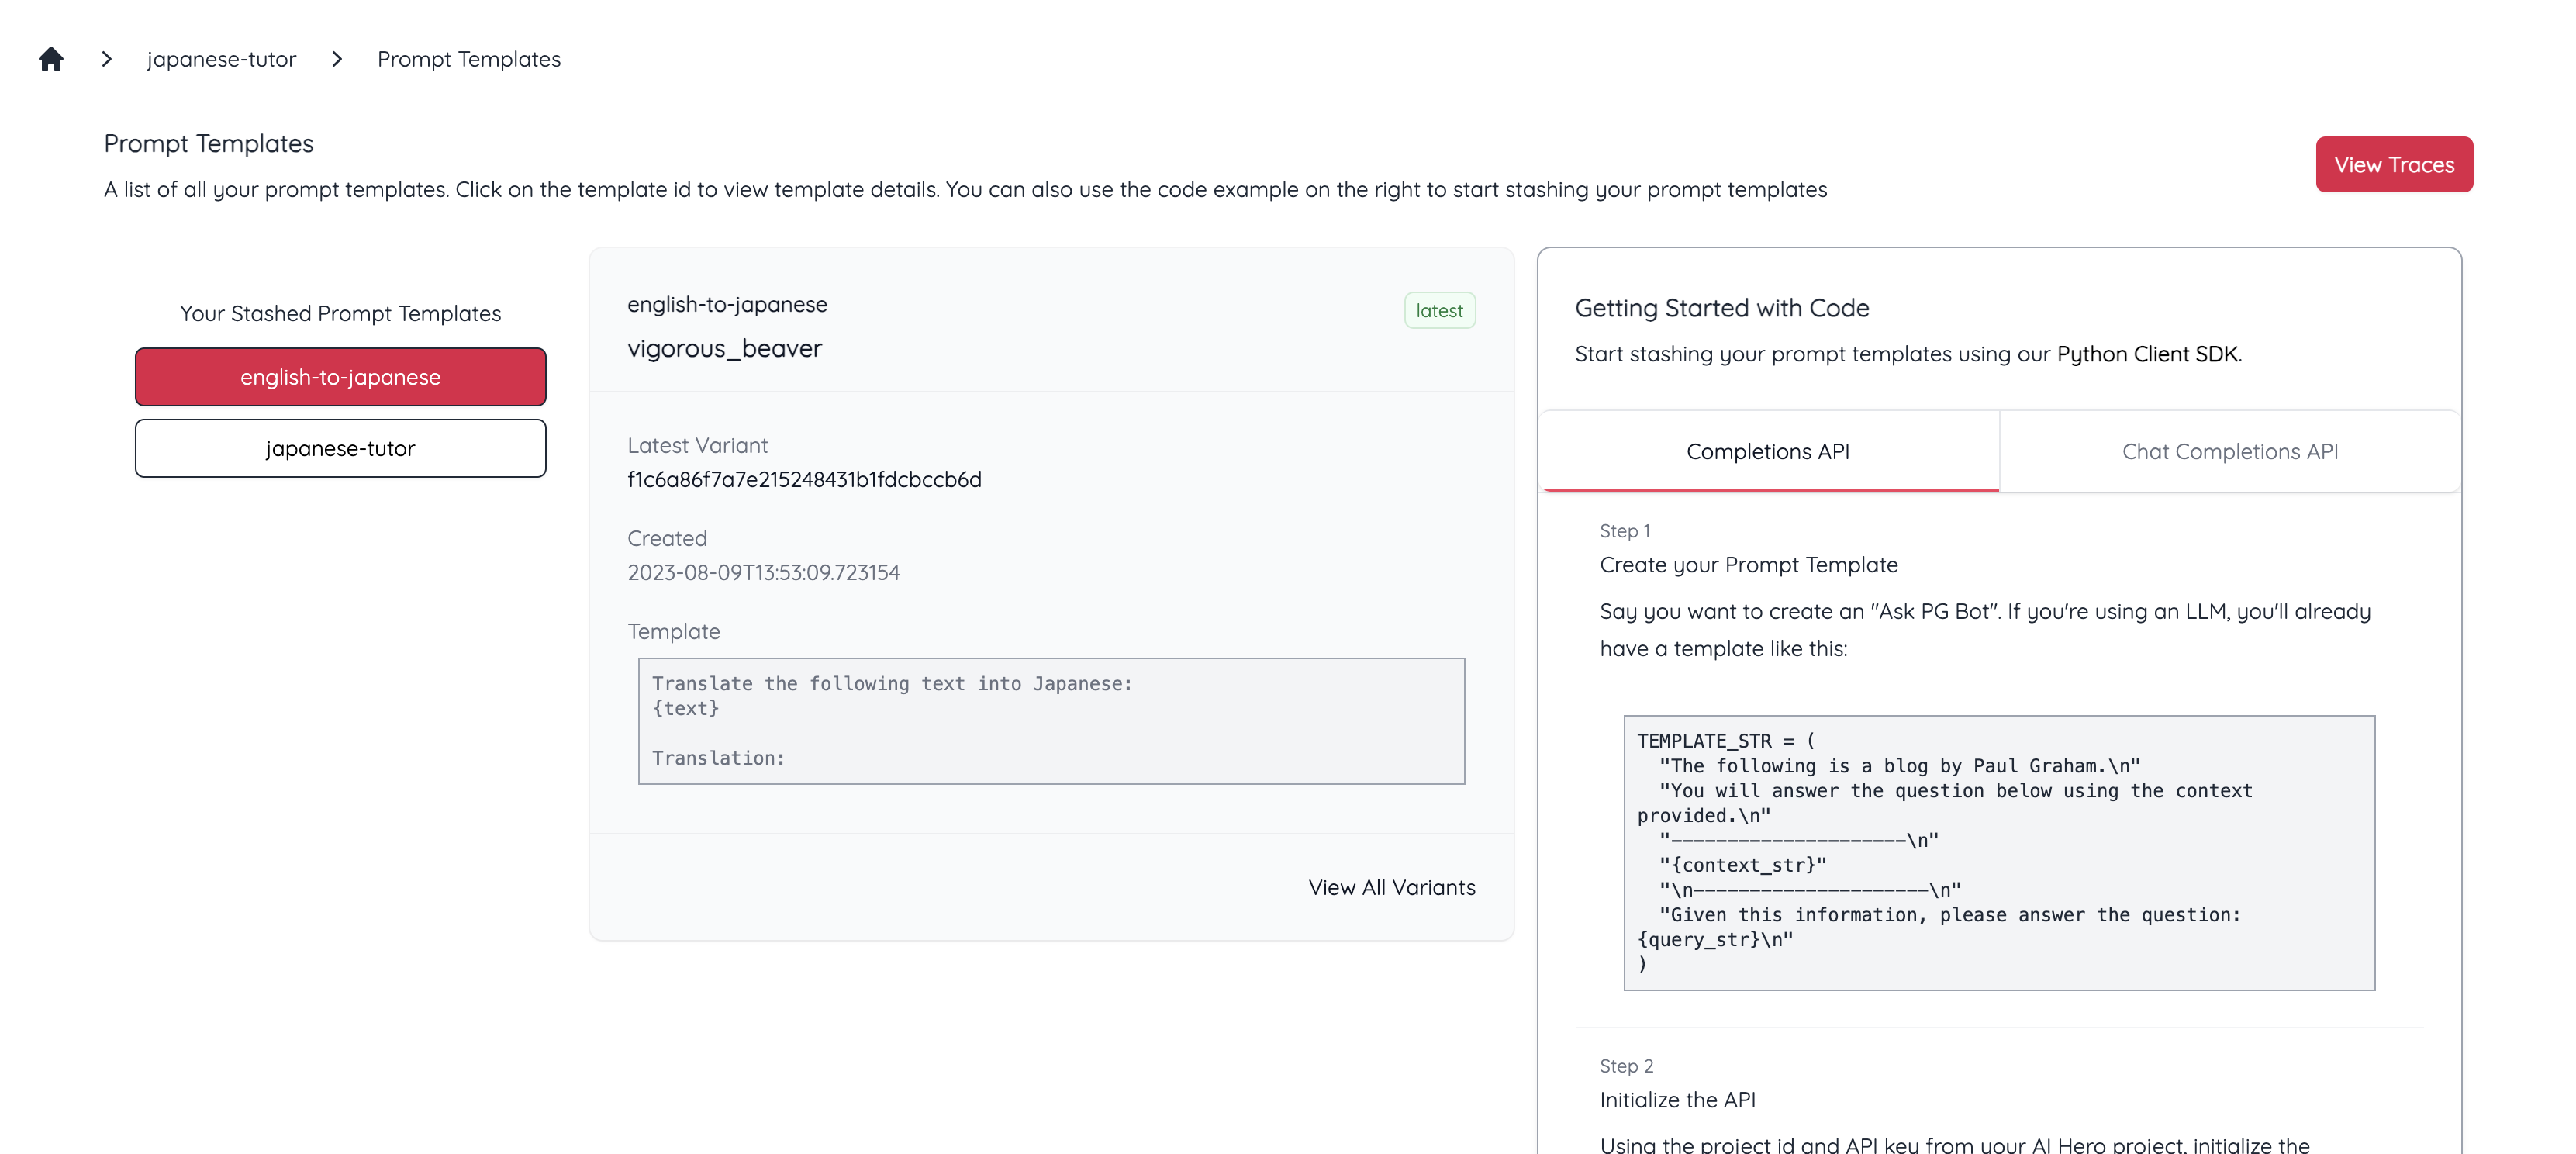

### Your first iteration - making the translation sound casual.

With your friend's feedback in mind, we'll reshape the prompt for a more relaxed tone. After adjusting, we'll preserve this new version using PromptStash.


In [15]:
casual_template = """Translate the following text into Japanese. Use a casual
tone that is used while talking with a friend.
Text:{text}

Translation:"""

casual_variant = ps.stash_template(template_id=TEMPLATE_ID, body=casual_template)
print(f"Prompt variant: {casual_variant}")

Prompt variant: e38edc5df93c246ea2267f5b70937e4b


You can see this version in the UI as well.

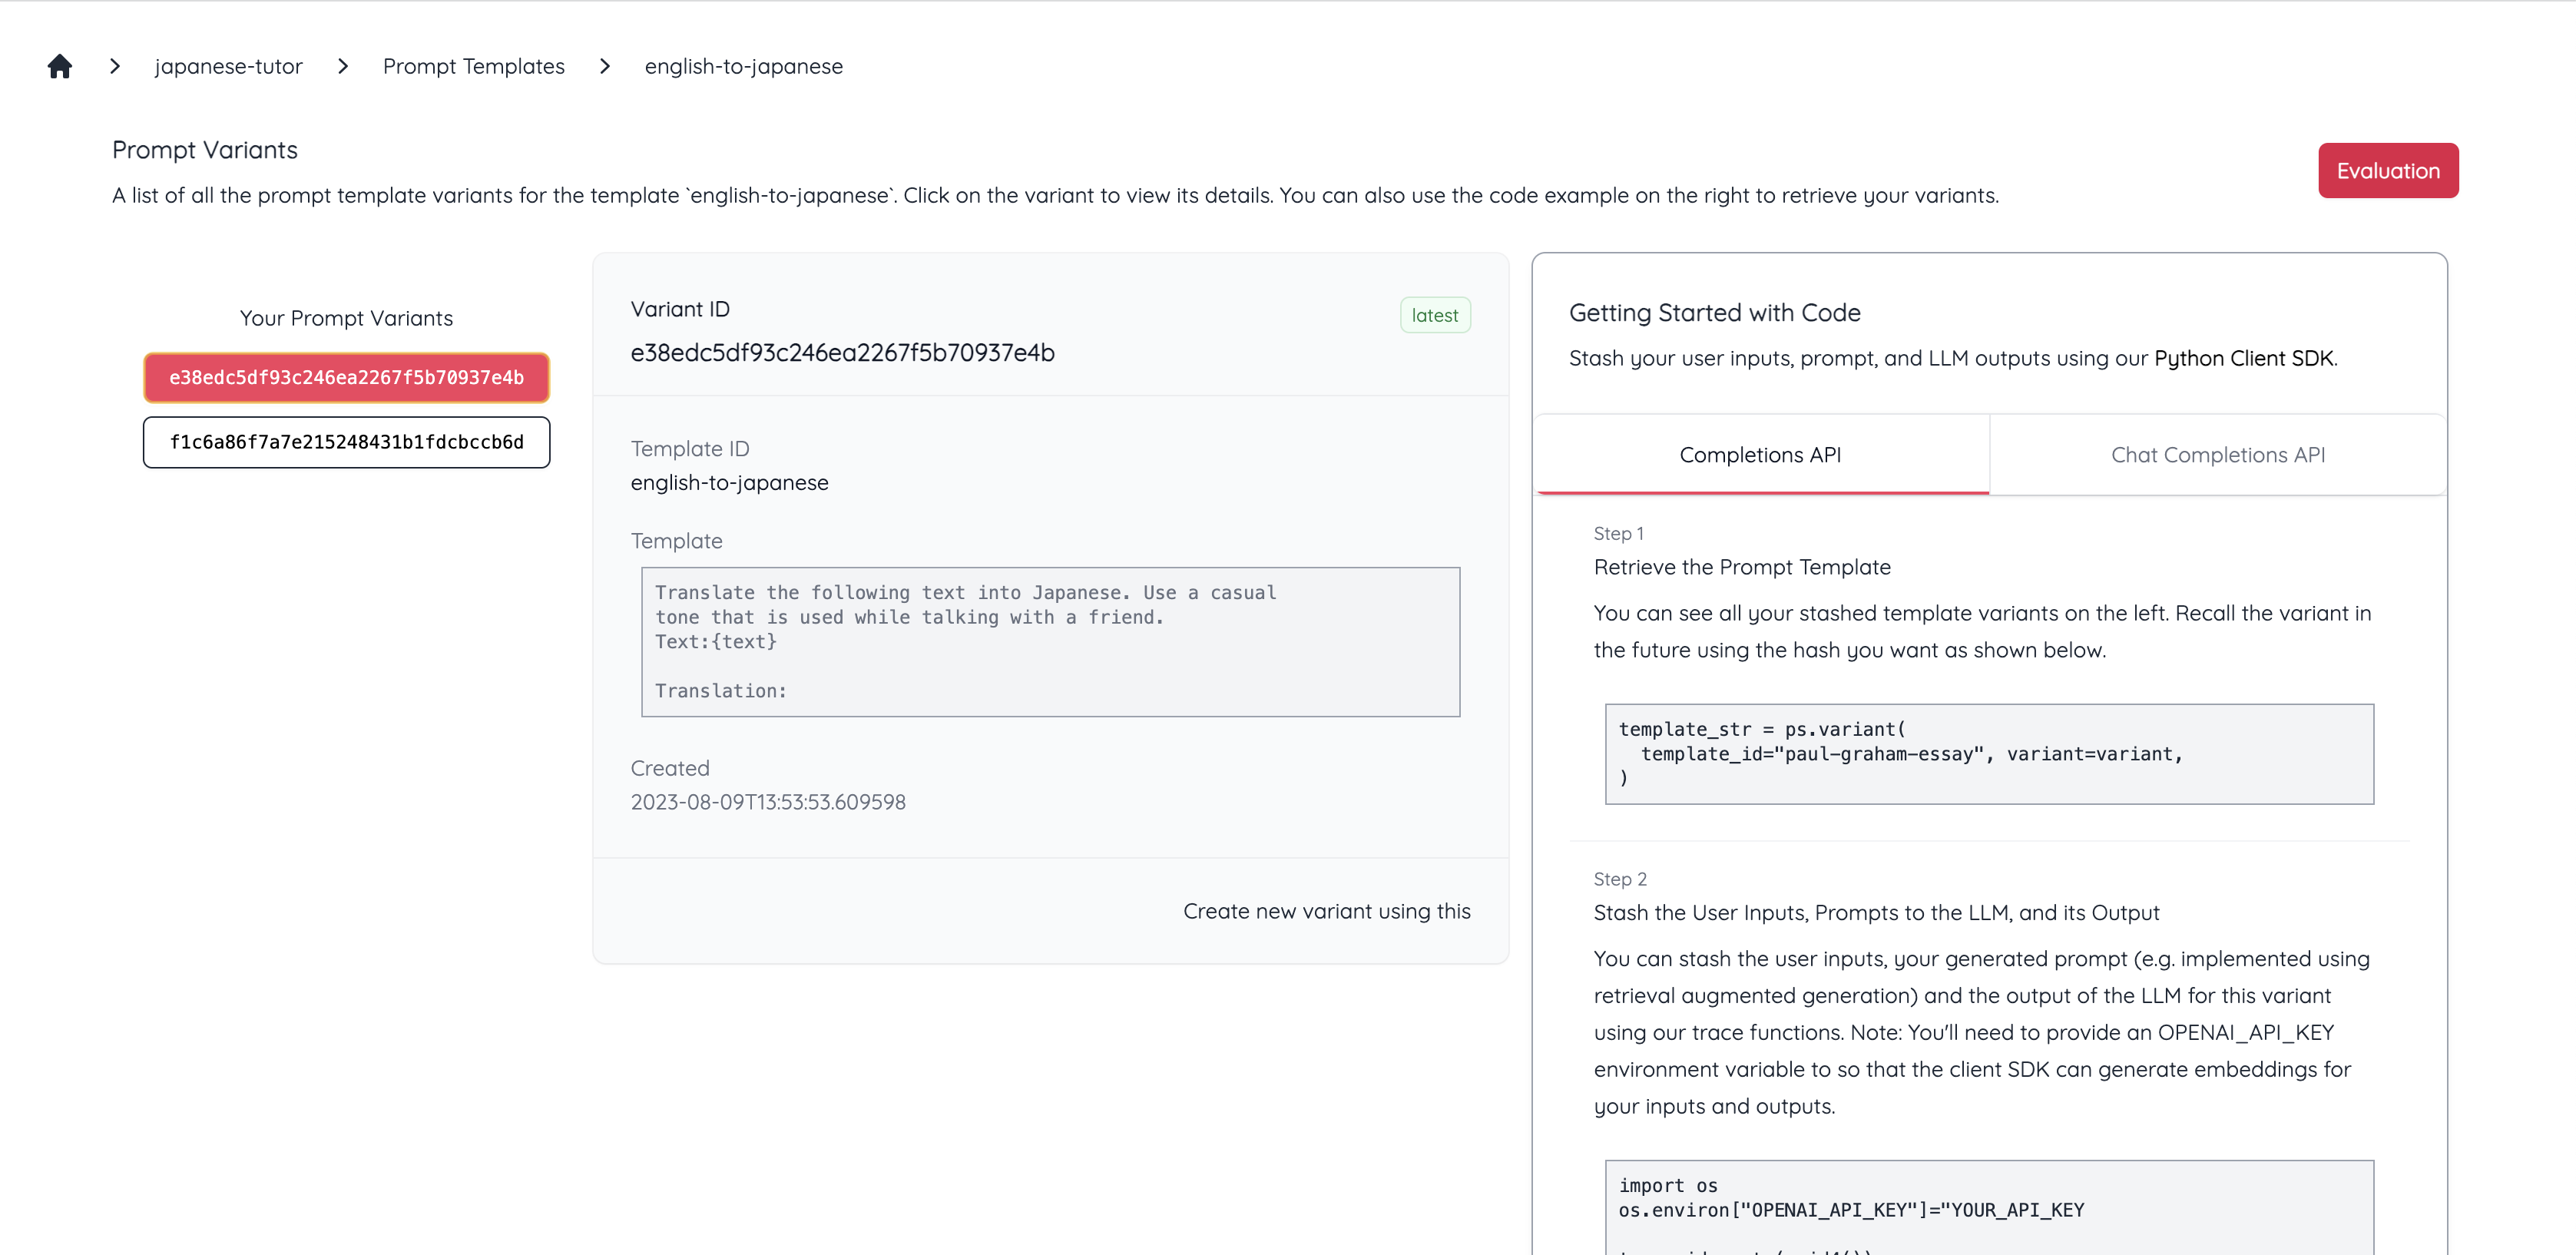

In [16]:
translation = translate(template=casual_template, text="Hello! My name is Rahul, How are you?", verbose=True)

English:
--------------
Hello! My name is Rahul, How are you?
----------------
Japanese:
--------------
やあ！私の名前はラフールだよ、元気？
----------------


### Enhancing the Experience
Your friend appreciates the casual tone! However, as the conversation flows, you identify a couple of enhancements to elevate the chat experience:

Convey emotions with an emoji at the end of your message.
Aid in verbal communication by providing an English pronunciation guide alongside the Japanese text.

#### Subsequent Iterations
Let's incorporate these features into our prompt.

In [17]:
helper_template = """Translate the following text into Japanese. Use a casual \
tone that is used while talking with a friend. You will end each line with an \
emoji that shows the emotions of the text. After the translation in the next line, \
return a guide to pronounce the Japanese text in English.
Text: {text}

Translation:"""

helper_variant = ps.stash_template(template_id=TEMPLATE_ID, body=helper_template)
print(f"Prompt variant: {helper_variant}")

Prompt variant: 504bc4b935dd1808afb45f4697c7bcd9


In [18]:
translation = translate(template=helper_template, text="Hello! My name is Rahul, How are you?", verbose=True)

English:
--------------
Hello! My name is Rahul, How are you?
----------------
Japanese:
--------------
こんにちは！私の名前はラーフです、お元気ですか？😊
Pronunciation Guide: Konnichiwa! Watashi no namae wa Raafu desu, ogenki desu ka?
----------------


### Evaluating Your Prompt: Building a Test Suite

A working prompt is a start, but ensuring its reliability is key. Let's construct a test suite with diverse cases to validate our prompt. A starter code for this is available in the "evaluation prompt" section.

Within PromptStash, tests come in two varieties:

1. **`test_*` Tests**: These are Python function tests. You'll need to implement and assert conditions based on your requirements.
  
2. **`ask_*` Tests**: These rely on GPT-3.5-turbo for evaluation. It's worth noting that this approach may not always yield optimal results. For these tests to function, the `OPENAI_API_KEY` environment variable is essential, allowing the client SDK to create embeddings for both inputs and outputs.

> **Important**: Utilizing your `OPENAI_API_KEY` will result in charges to your OpenAI account. We strongly advise setting spending limits on your OpenAI account to prevent unintended expenses.


In [19]:
import emoji
from aihero.eval import PromptTestSuite

class TranslatorBotTests(PromptTestSuite):
    def ask_is_japanese(self) -> str:
        return "Does the text contain Japanese?"

    def test_has_pronounciation_guide(self, output):
        assert "pronounciation:" in output.lower() or "pronunciation guide:" in output.lower(), "The output doesn't contain a pronounciation guide."
        
    def test_has_emoji(self, output):
        assert emoji.emoji_count(output) > 0, "The output doesn't contain any emoji."

    def ask_is_casual(self) -> str:
        return "Is the text in japanese using casual form (i.e. suitable for friends)?"

TEST_TEMPLATE_ID = "english-to-japanese-test"

ts = ps.build_test_suite(
  test_suite_id=TEST_TEMPLATE_ID,
  test_suite_cls=TranslatorBotTests
)

We'll create a few test cases:

In [20]:
TEST_CASES = [
    "Hi! What's up?",
    "What are you up to?",
    "I'm hungry! What should I eat?",
    "Do you want to hang out?",
    "OMG! Did you hear the latest BTS song?"
]

# Note: If you have a longer list, these can come from a csv file.

Let's tun these test cases against our prompt template. We first iterate through them and generate and cache the output. We'll then run the tests with the outputs generated for each of the inputs.

In [21]:
import time
from datetime import date

# We'll store the results and the time it takes into a list so that we can run the test suite on it.
times = []
completions = []
for test_case in TEST_CASES:
    tic = time.perf_counter()
    translation = translate(template=helper_template, text=test_case, verbose=True)
    toc = time.perf_counter()
    times.append(toc - tic)

    # Since our tests will run against the prompt, input and output, we'll create the right texts.
    prompt = helper_template.format(text=test_case)
    completions.append(
        {
            "inputs": {"text": test_case},
            "rendered_inputs": f"English: {test_case}",
            "prompt": prompt,
            "output": translation,
        }
    )
    print() # Newline to separte test cases.

# Next, we calculate the average time taken, and run the test suite on our test cases.
avg_time = sum(times) / len(times)

ts.run(
    template_id=TEMPLATE_ID,
    variant=helper_variant,
    completions=completions,
    model={"name": MODEL, "version": date.today().strftime("%Y-%m-%d")},
    metrics={"times": times, "avg_time": avg_time},
    other={"embedding_model": "text-embedding-ada-002"},
)

English:
--------------
Hi! What's up?
----------------
Japanese:
--------------
こんにちは！どうしたの？😊
Pronunciation: Konnichiwa! Dōshita no?
----------------

English:
--------------
What are you up to?
----------------
Japanese:
--------------
何してるの？😊
Pronunciation: Nani shiteru no?
----------------

English:
--------------
I'm hungry! What should I eat?
----------------
Japanese:
--------------
私はお腹が空いてる！何を食べよう？🤔
Pronunciation Guide: Watashi wa onaka ga suiteru! Nani o tabeyou?
----------------

English:
--------------
Do you want to hang out?
----------------
Japanese:
--------------
今夜遊びに行く？😊
Pronunciation Guide: Konya asobi ni iku?
----------------

English:
--------------
OMG! Did you hear the latest BTS song?
----------------
Japanese:
--------------
うわー！最新のBTSの曲聞いた？😮
Pronunciation Guide: Uwa-! Saishin no BTS no kyoku kiita?
----------------

Test Case: 'English: Hi! What's up?'
Running ask_is_casual... 

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/aihero/eval.py", line 274, in run
    raise AIHeroException(
aihero.exceptions.AIHeroException: Is the text in japanese using casual form (i.e. suitable for friends)? - did not return pass/failPASS

The output text in Japanese is in a casual form, which is suitable for friends. The use of "Konnichiwa!" (meaning "Hello!") and "Dōshita no?" (meaning "What's up?") indicates a friendly and informal tone.


FAIL
Running ask_is_japanese... 

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/aihero/eval.py", line 274, in run
    raise AIHeroException(
aihero.exceptions.AIHeroException: Does the text contain Japanese? - did not return pass/failPASS

Yes, the output text contains Japanese characters. The phrases "こんにちは！" and "どうしたの？" are written in Japanese.


FAIL
Running test_has_emoji... PASS
Running test_has_pronounciation_guide... FAIL
Test Case: 'English: What are you up to?'
Running ask_is_casual... PASS
Running ask_is_japanese... PASS
Running test_has_emoji... PASS
Running test_has_pronounciation_guide... FAIL
Test Case: 'English: I'm hungry! What should I eat?'
Running ask_is_casual... FAIL
Running ask_is_japanese... PASS
Running test_has_emoji... PASS
Running test_has_pronounciation_guide... PASS
Test Case: 'English: Do you want to hang out?'
Running ask_is_casual... FAIL
Running ask_is_japanese... PASS
Running test_has_emoji... PASS
Running test_has_pronounciation_guide... PASS
Test Case: 'English: OMG! Did you hear the latest BTS song?'
Running ask_is_casual... PASS
Running ask_is_japanese... PASS
Running test_has_emoji... PASS
Running test_has_pronounciation_guide... PASS
PASS/FAIL SUMMARY:
	PASSED	FAILED	ERRORED	TOTAL	TEST
	2	2	1	5	ask_is_casual
	4	0	1	5	ask_is_japanese
	5	0	0	5	test_has_emoji
	3	2	0	5	test_has_pronounciation_g

You can also see the details of the test run in the evaluation page on the UI:


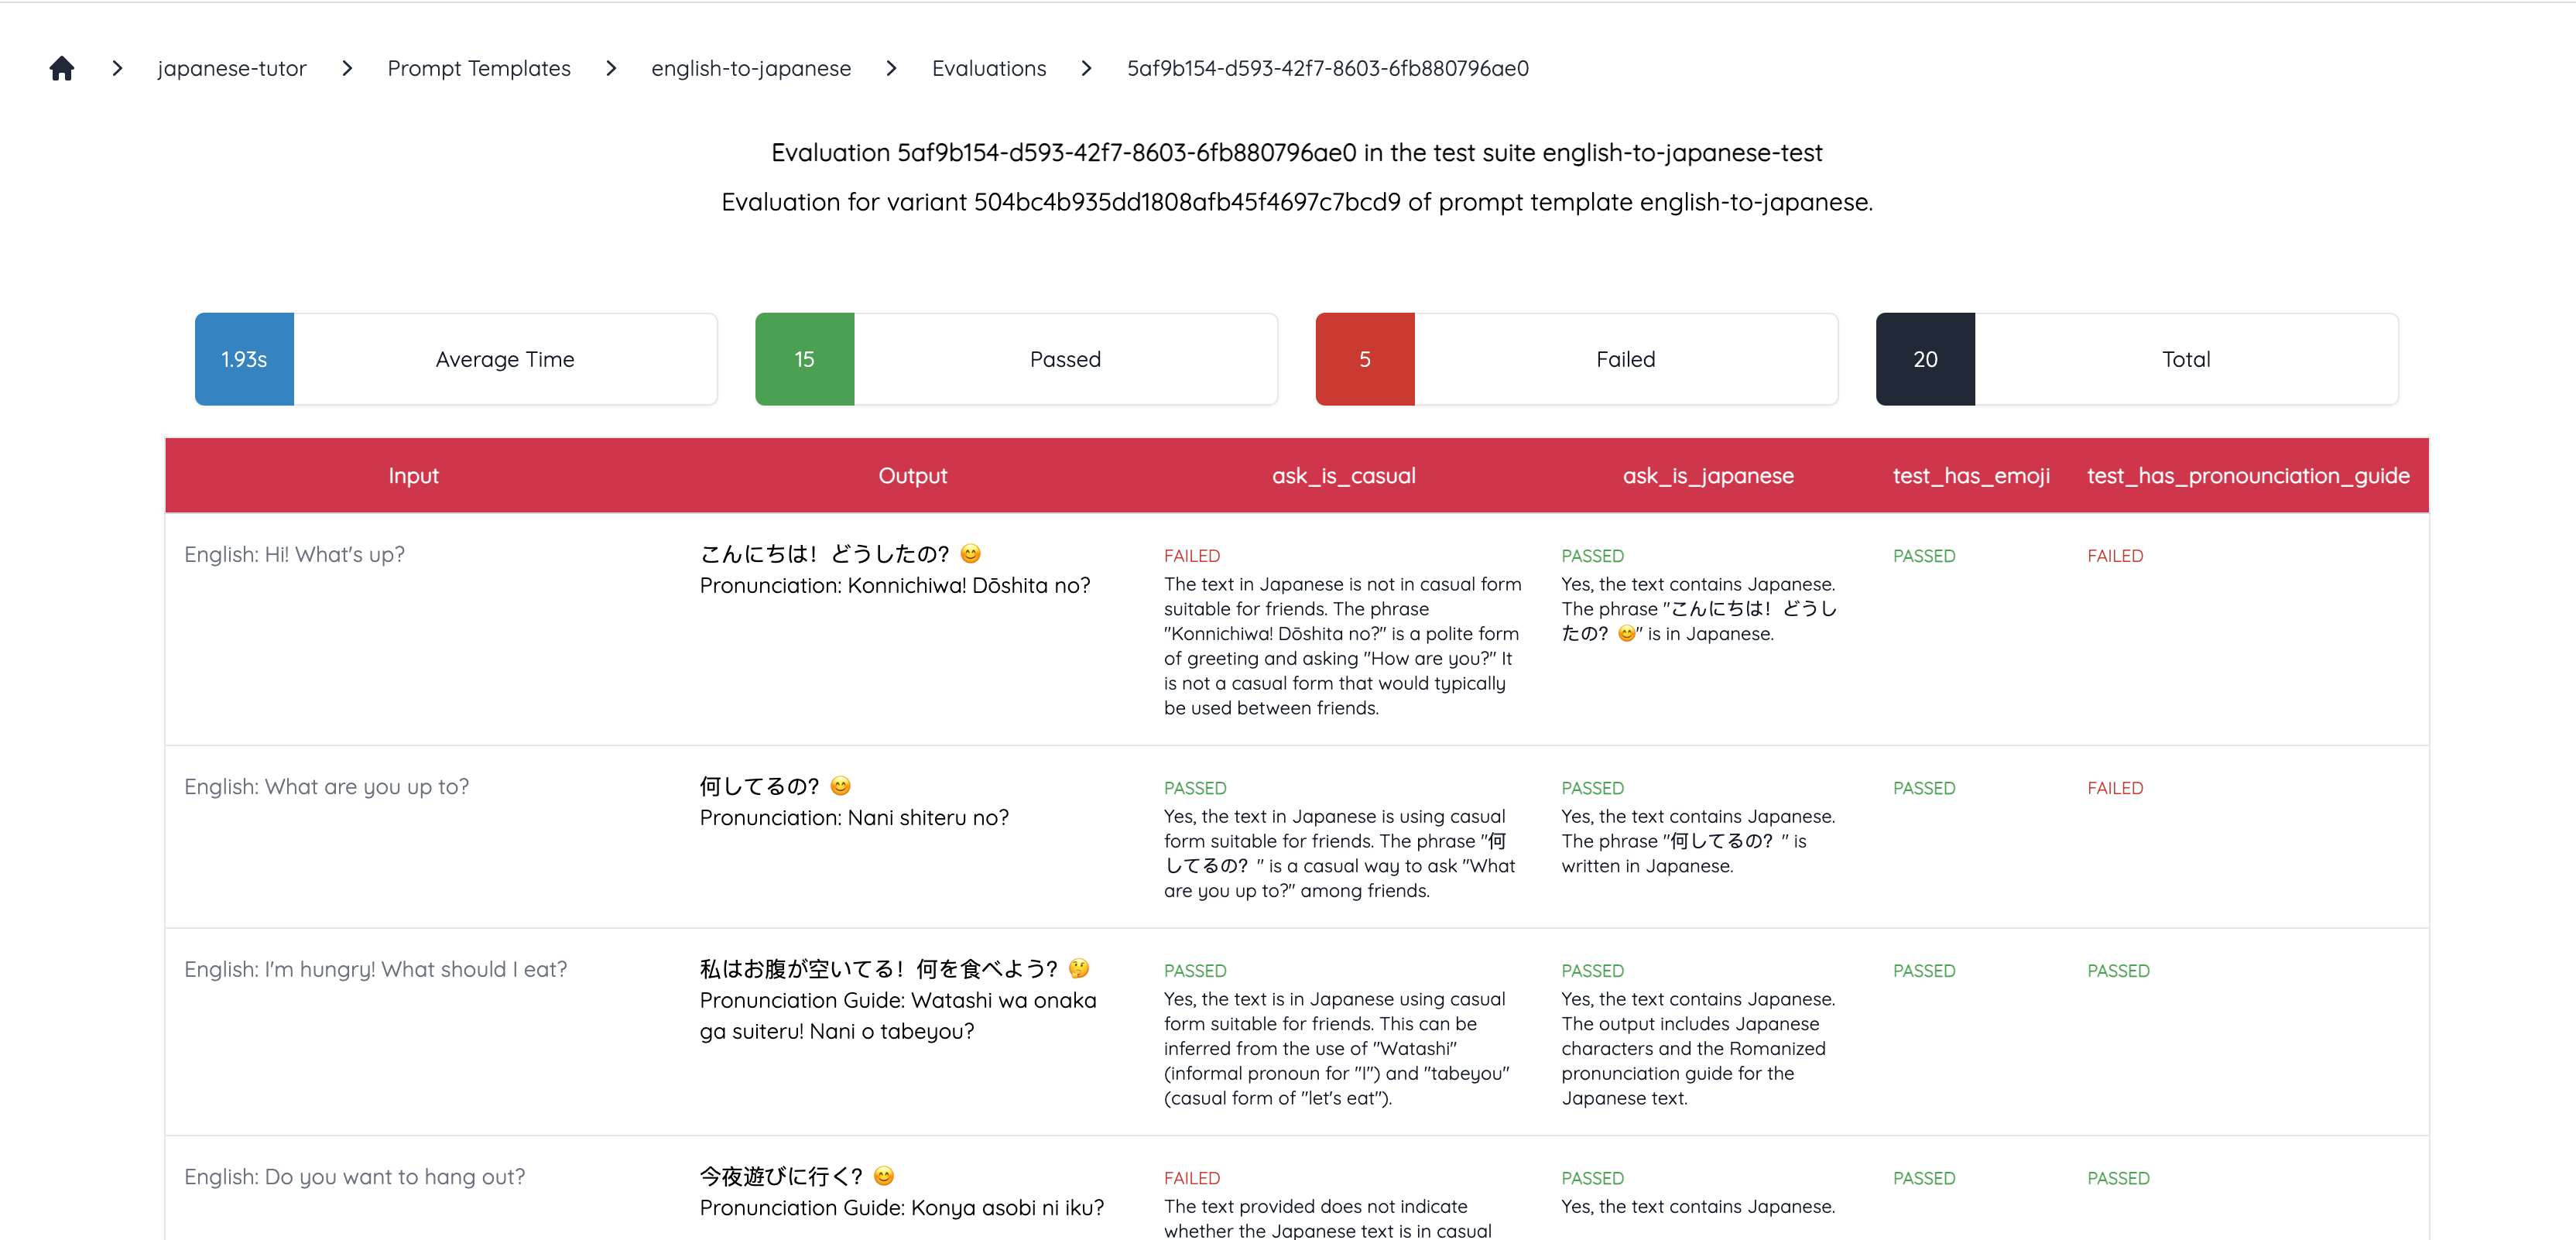

While some of these tests, could be run better, we're all set to start using our translator with our friend!

## Deploying the Variant in Production

With your prompt refined, stashed, and tested, it's time to bring it to life in a real-world application. To integrate it into your app, you'll first retrieve the desired variant from PromptStash, then utilize it in your production environment. Below, we provide a helper class to simplify this integration:

In [27]:
import os
import openai
import dotenv
from datetime import date
from uuid import uuid4
from aihero import promptstash

MODEL = "text-davinci-003"
MAX_TOKENS = 250
TEMPERATURE = 0

# Load the environment variables
dotenv.load_dotenv()

# Get the API key from the environment
openai.api_key = os.environ["OPENAI_API_KEY"]
ps = promptstash(project_id=os.environ["AI_HERO_PROJECT_ID"], api_key=os.environ["AI_HERO_PROJECT_API_KEY"])

class PromptStashOpenAICompletionsHelper:

    def __init__(self, template_id: str, variant:str):
        self.template_id = template_id
        self.variant = variant
        self.template = ps.variant(template_id, variant)

    def complete(self, inputs, trace_id: str=str(uuid4())):
        prompt = self.template.format(**inputs).strip()
        response = openai.Completion.create(
            model=MODEL,
            prompt=prompt.strip(),
            max_tokens=MAX_TOKENS,
            temperature=TEMPERATURE
        )
        output = response["choices"][0]["text"].strip()
        
        step_id = str(uuid4())

        ps.stash_completion(
            trace_id=trace_id,
            step_id=step_id,
            template_id=TEMPLATE_ID,
            variant=variant,
            prompt=prompt,
            output=output,
            inputs=inputs,
            rendered_inputs=f"Text: {inputs['text']}",
            model={"name": "openai-davinci-003", "version": date.today().strftime("%Y-%m-%d")},
            metrics={"time": (toc - tic)},
            other={"embedding_model": "text-embedding-ada-002"},
        )
        return output, step_id
        

    def feedback(self, trace_id: str, for_step_id:str, thumbs_up: bool, thumbs_down: bool, correction: str = None):
        ps.stash_feedback(trace_id=trace_id, for_step_id=for_step_id, thumbs_up=thumbs_up, thumbs_down=thumbs_down, correction=correction)


In [28]:
prompt_stash_openai_completions_helper = PromptStashOpenAICompletionsHelper(template_id=TEMPLATE_ID, variant=helper_variant)

text = "You're my best friend!"

print(f"English:\n--------------\n{text}\n----------------")
trace_id = str(uuid4())
translation, step_id = prompt_stash_openai_completions_helper.complete(trace_id=trace_id, inputs={"text": text})
print(f"Japanese:\n--------------\n{translation}\n----------------")

English:
--------------
You're my best friend!
----------------
Japanese:
--------------
君は俺の最高の友達だよ！😊
Pronunciation Guide: Kimi wa ore no saikō no tomodachi da yo!
----------------


### Bonus Tips for Effective Prompt Management:

1. **Continuous Improvement**: Regularly iterate on your prompt to fine-tune its performance.
2. **Preserve All Versions**: Ensure you stash every input and output to maintain a comprehensive history.
3. **Gather Feedback**: Whenever possible, collect feedback on your prompt. Direct user insights can provide invaluable guidance for enhancement.


In [29]:
translation = prompt_stash_openai_completions_helper.feedback(trace_id=trace_id, for_step_id=step_id, thumbs_up=True, thumbs_down=False)

Prompt stashed.
Feedback stashed.


You can see your trace for trace_id and all its steps in the UI. 

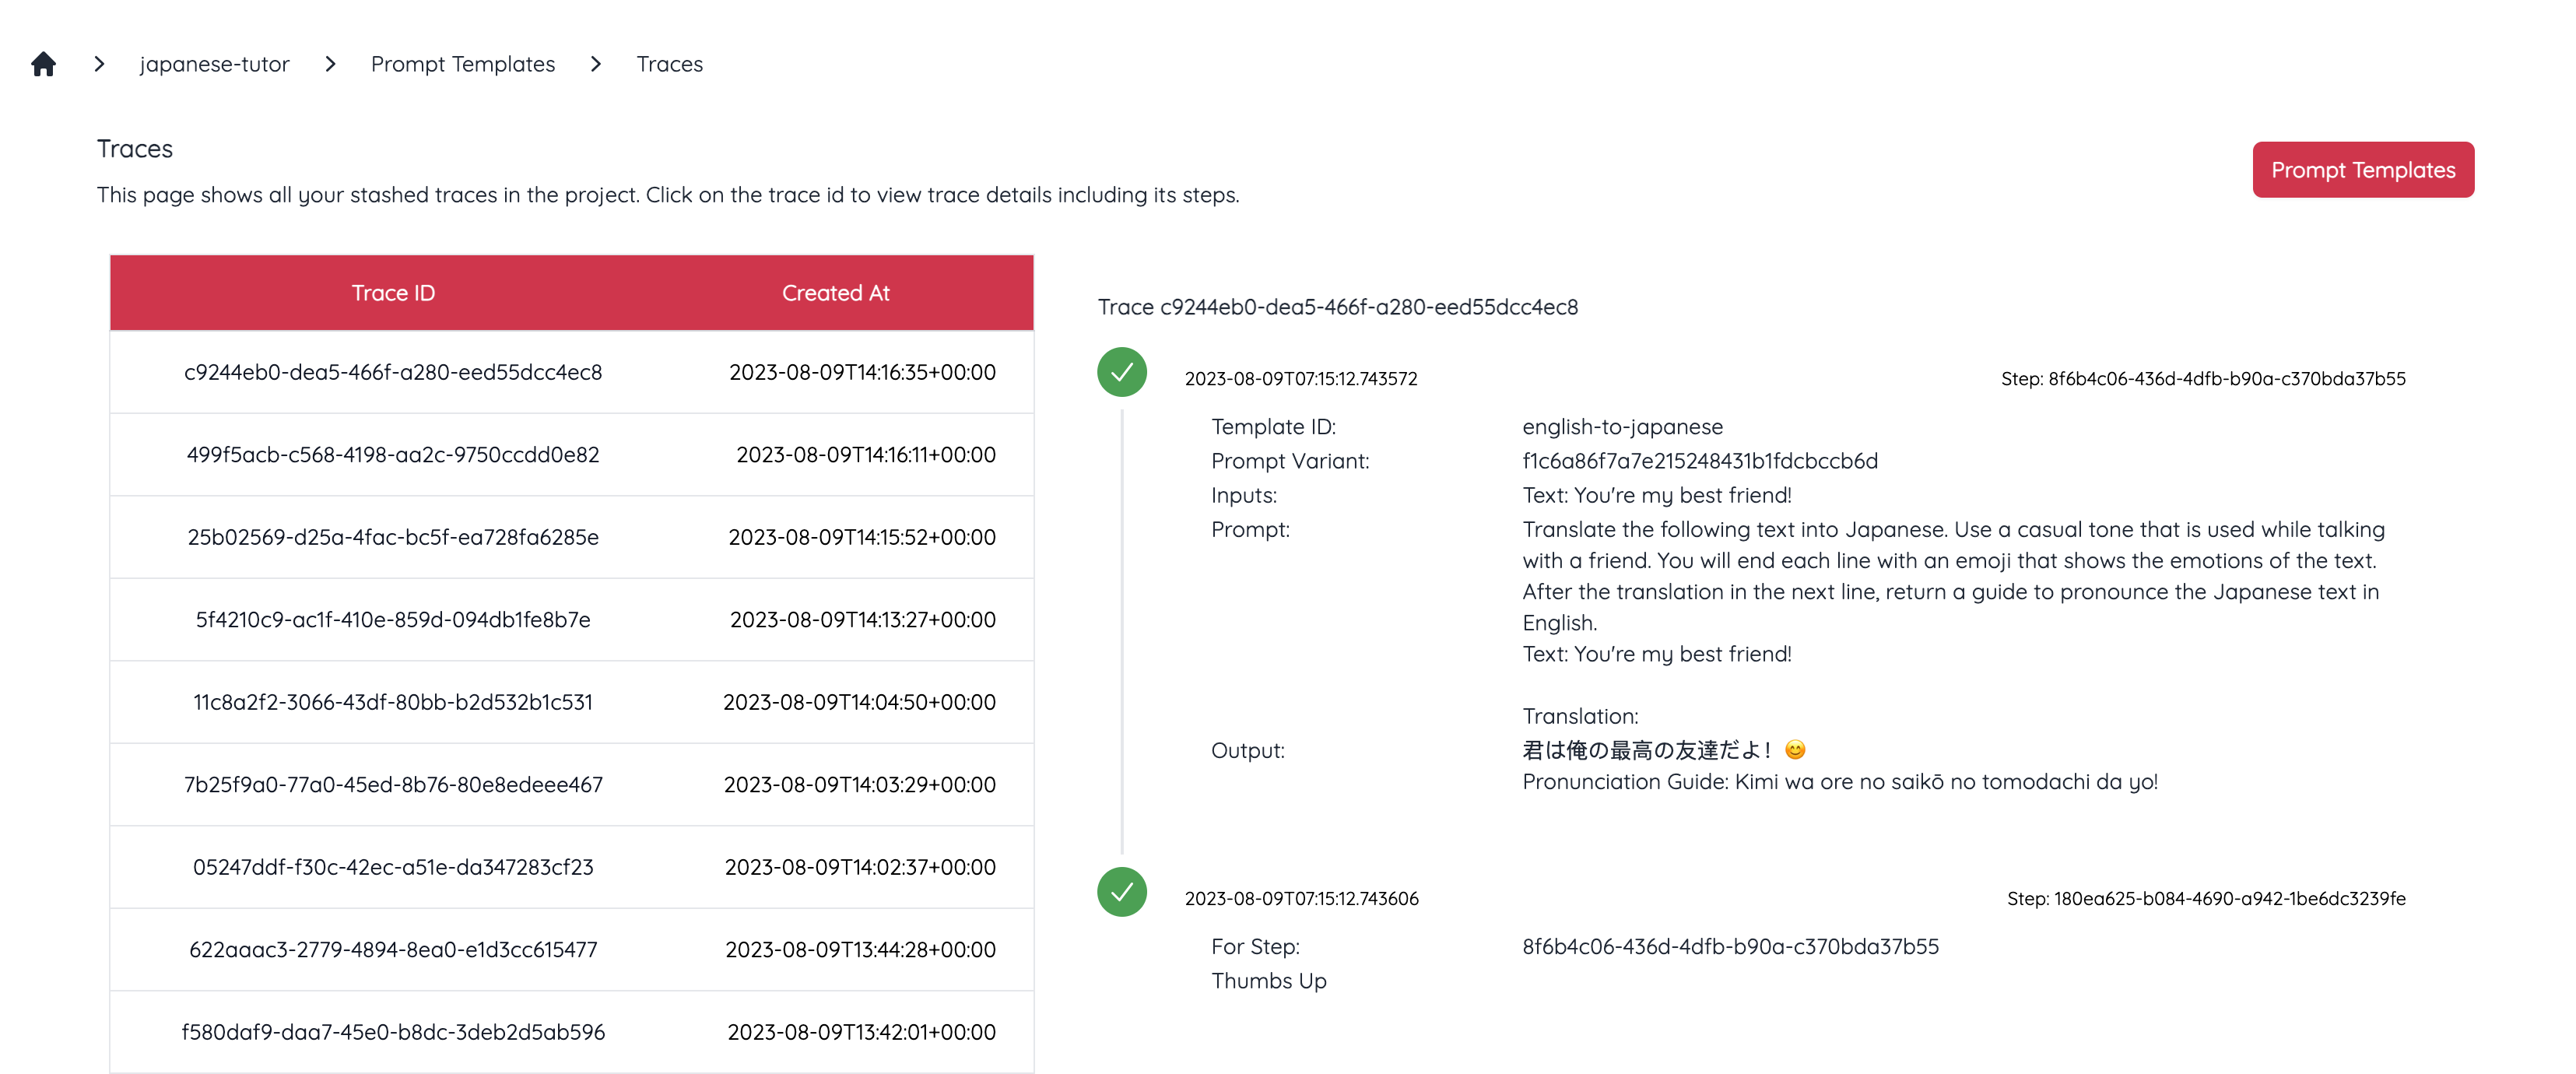

### Tutorial Summary:

In this tutorial, we delved into the world of **PromptOps** – the end-to-end lifecycle management of prompts. We commenced by exploring the OpenAI's Completions API and the significance of refining prompts for optimal outcomes. Using a fun use case of translating English to Japanese, we iterated upon our prompts, made them sound casual, added emojis and pronunciation guides, and stashed each version using PromptStash to prevent loss. We emphasized the importance of testing our prompts and provided guidance on deploying them in production. Along the way, we sprinkled in some bonus tips to ensure your prompt iterations are both effective and efficient.

#### Wrapping Up:

That concludes our journey into the realm of **PromptOps**! We hope this guide empowers you to master your prompts, making them more dynamic and responsive. Dive in, experiment, and always remember the value of continuous iteration.

For any questions, insights, or feedback, please reach out to **team@aihero.studio**. Here's to your success in prompt optimization!
